In [1]:
import pandas as pd
import json
import numpy as np
import pickle #to save files

from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.svm import SVC, OneClassSVM

from sklearn.metrics import precision_score, recall_score,f1_score

import nolds
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.core.debugger import Tracer
import synapseclient
syn=synapseclient.login()

Welcome, Nicholas Shawen!



## Helper fcns

In [3]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur','Sen_X','Sen_Y','Sen_Z','Sen_FFTX',
                    'Sen_FFTY','Sen_FFTZ']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
    
    #jerk moments on magnitude
    jerk = rawdata.iloc[:,-1].diff().values
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total
    
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
    sH_raw = []; sH_fft = []
    #on magnitude
#     x = rawdata.iloc[:,-1]
#     n = len(x) #number of samples in clip
#     Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
#     sH_raw=nolds.sampen(x) #samp entr raw magnitude
#     f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#     sH_fft=(nolds.sampen(Pxx_den)) #samp entr fft
    #Sen on each axis
    for a in range(3):
        x = rawdata.iloc[:,a]
        n = len(x) #number of samples in clip
        Fs = np.mean(1/(np.diff(rawdata_wtime.timestamp))) #sampling rate in clip
        sH_raw.append(nolds.sampen(x)) #samp entr raw data
        f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
        sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments,sH_raw,sH_fft))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list


def gen_clips(rawdata,clipsize=5,overlap=0,interp=False):
    
    len_tol = 0.8   #% of the intended clipsize below which clip is not used (deprecated for now)
    #reindex time (relative to start)
    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    #create clips data
    deltat = np.median(np.diff(rawdata.timestamp))
    idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
    clips = []
    for i in idx:
        c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
        if interp:
            if len(c) == 250:
                clips.append(c)
            #resample clip if not enough samples are there
            elif (len(c) >200) & (len(c)<250): #for now hard code clip size (enforce 250 samples)
                t = c.timestamp.values
                tnew = np.linspace(t[0],t[-1],250)  
                x_res = resample(c.iloc[:,1].values,num,tnew)[0]
                y_res = resample(c.iloc[:,2].values,num,tnew)[0]
                z_res = resample(c.iloc[:,3].values,num,tnew)[0]
                mag_res = resample(c.iloc[:,4].values,num,tnew)[0]
                cres = pd.DataFrame(data=np.vstack((tnew,x_res,y_res,z_res,mag_res)).T,columns=list(c.columns))
                clips.append(cres)
        else:
            if len(c) > 10: #at least n data points in clip
                clips.append(c)
#         if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
    return clips

#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin; #if nbins = -1 does not bin the data
#if binavg is True it averages the PSD within bins to reduce PSD noise
#**DO NOT USE - NEED TO FIX BUG*** 
def powerspectra(x,fm,fM,nbins=-1,relative=False,binavg=True):
    
    #feature labels (if binned)
    labels=[]
    if nbins > 0:
        s = np.linspace(fm,fM,nbins)
        lax = ['X','Y','Z']
        for l in lax:
            for i in s:
                labels.append('fft'+l+str(int(i)))
        
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.nanmean(1/(np.diff(x.timestamp))) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    x = x.drop('timestamp',axis=1)
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
        
    if nbins > 0:
        #power spectra between fm-fM Hz
        bin1 = int(timestep*n*fm)
        bin2 = int(timestep*n*fM)
        bins = np.linspace(bin1,bin2,nbins,dtype=int)
    #     print(bins/(round(timestep*n)))

        #average power spectra within bins - CHECK FOR BUG!
        if binavg:
            deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
            Pxxm = []
            for i in bins:
                start = int(max(i-deltab,bins[0]))
                end = int(min(i+deltab,bins[-1]))
                Pxxm.append(np.nanmean(Pxx.iloc[start:end,:].values,axis=0))            
            Pxxm = np.asarray(Pxxm)
            Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
            return Pxx, labels

        else:
            return Pxx.iloc[bins,:], labels
    #no binning
    else:
        return Pxx

    
#PSD on magnitude using Welch
def power_spectra_welch(rawdata,fm,fM):
    x = rawdata.iloc[:,-1]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (f<=fM)&(f>=fm)
    f=f[inds]
    Pxx_den=Pxx_den[inds]
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])

    return Pxxdf

    
#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
def filter_signal(rawdata,cutoff=0.75,ftype='highpass',order=4):

    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    x = rawdata.iloc[:,1:].values
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate    
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
    b,a = butter(order,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    t = np.expand_dims(t,axis=1)
    rawdatafilt = pd.DataFrame(data=np.hstack((t,xfilt)),columns=rawdata.columns)
    return rawdatafilt

#X,y are numpy arrays with features and target
#Fnew is dataframe storing the posteriors (new features)
#returns mean feature importance
def LOSOCV(X,y,groups,models,Fnew):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for clf,model_name in models:

        Prec_all=[]; Rec_all=[]; f1_train=[]; Posteriors=[] 

        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte) #posterior scores on left out subject
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            f1_train.append(f1_score(ytr,ypred_train))

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Prec = precision_score(yte,ypred)
                Rec = recall_score(yte,ypred)
            else:
                print('no positive examples for current test subj')
                Sens = np.nan
            Prec_all.append(Prec); Rec_all.append(Rec)

            #store posteriors from current classifier and subject
#             Fnew[model_name].iloc[test_index]=yscore
            Fnew.loc[test_index,model_name]=yscore

            
        #mean across all subjects
        print(('%s, mean F1 on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(f1_train),2*np.nanstd(f1_train)/np.sqrt(len(f1_train))))
        print(('%s, mean Prec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Prec_all),2*np.nanstd(Prec_all)/np.sqrt(len(Prec_all))))
        print(('%s, mean Rec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Rec_all),2*np.nanstd(Rec_all)/np.sqrt(len(Rec_all))))

    return Fnew


#train classifiers on input training features Xtr and target ytr; 
#returns posterior predictions Fnew from each clf on test data X
def testdata_stacking(Xtr,ytr,Xte,models,Fnew):

    #train multiple classifiers
    for clf,model_name in models:
        print('Training %s'%model_name)
        clf.fit(Xtr,ytr)
        print('Computing prediction %s'%model_name)
        yscore = clf.predict_proba(Xte) #posterior scores on test data
        yscore = yscore[:,1]
        #store posteriors from current classifier on test data
        Fnew.loc[:,model_name]=yscore

    return Fnew


In [4]:
def findnanrows(df):

    empty_ind = []
    nans_found=0; n_empty=0
    for i in range(len(df)):

        f = df.iloc[i,:].path
        rawdata = pd.read_csv(f,sep='\t') #load file

        #remove nans
        rawdata = rawdata.astype('float64') #make sure everything is float
        if sum(np.sum(rawdata.isnull())) > 0:
            nans_found+=1 # of files w nans
            rawdata = rawdata.dropna() #drop nans

        #store row indices of empty files
        if rawdata.empty == True:
            n_empty+=1 #empty files
            empty_ind.append(i)
    print('Files w nans: %d'%nans_found)
    print('Files w 0 non-nan rows %d'%n_empty)
    return empty_ind

## Pull Train data (remove empty files rows)

In [123]:
# symptom_score = 'bradykinesiaScore'
# symptom_score = 'dyskinesiaScore'
symptom_score = 'tremorScore'

In [124]:
# q_train = syn.tableQuery("SELECT * from syn10495809 where bradykinesiaScore is not null")

In [125]:
# q_train = syn.tableQuery("SELECT * from syn10495809 where dyskinesiaScore is not null")

In [126]:
q_train = syn.tableQuery("SELECT * from syn10495809 where tremorScore is not null")

In [127]:
paths_train = syn.downloadTableColumns(q_train,'dataFileHandleId')

In [128]:
df_train = q_train.asDataFrame()
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1.0,/Users/nicholasshawen/.synapseCache/28/1728602...
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1.0,/Users/nicholasshawen/.synapseCache/30/1728603...
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1.0,/Users/nicholasshawen/.synapseCache/34/1728603...
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1.0,/Users/nicholasshawen/.synapseCache/36/1728603...
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1.0,/Users/nicholasshawen/.synapseCache/42/1728604...


In [129]:
#remove nanrows
inds = findnanrows(df_train)
df_train=df_train.drop(df_train.index[inds])
y_train = df_train[symptom_score].values
len(df_train)

Files w nans: 227
Files w 0 non-nan rows 120


3547

## Pull test data

In [12]:
q_test = syn.tableQuery("SELECT * from syn10701954 where dyskinesiaScore = 'Score'")

In [13]:
paths_test = syn.downloadTableColumns(q_test,'dataFileHandleId')

In [14]:
df_test = q_test.asDataFrame()
df_test['path']=df_test.dataFileHandleId.astype(str).map(paths_test)
df_test.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
12963_10,17287647,GENEActiv,14_BOS,1,Boston,ftnl1,1,Right,NotApplicable,Score,NotApplicable,/Users/nicholasshawen/.synapseCache/647/172876...
12965_10,17287654,GENEActiv,14_BOS,1,Boston,ftnl2,1,Right,NotApplicable,Score,NotApplicable,/Users/nicholasshawen/.synapseCache/654/172876...
12968_10,17287666,Pebble,14_BOS,1,Boston,ftnr1,1,Left,NotApplicable,Score,NotApplicable,/Users/nicholasshawen/.synapseCache/666/172876...
12970_10,17287674,Pebble,14_BOS,1,Boston,ftnr2,1,Left,NotApplicable,Score,NotApplicable,/Users/nicholasshawen/.synapseCache/674/172876...
12975_10,17287694,GENEActiv,14_BOS,1,Boston,raml1,1,Right,NotApplicable,Score,NotApplicable,/Users/nicholasshawen/.synapseCache/694/172876...


In [15]:
len(df_test)

660

In [16]:
#remove nanrows
inds = findnanrows(df_test)
df_test=df_test.drop(df_test.index[inds])
len(df_test)

Files w nans: 51
Files w 0 non-nan rows 17


643

## Metadata features


In [130]:
df = df_train
# df = df_test #to run on df_test

In [131]:
len(df)

3547

In [132]:
X_meta = df[['dataFileHandleId','device','patient','session','site','task','visit','deviceSide']]
y_meta = df[symptom_score]

In [133]:
#encode cat vars with num
le = preprocessing.LabelEncoder()
X_meta_copy = X_meta.copy()
cat_cols = X_meta.select_dtypes(['object']).columns
for c in cat_cols:
    X_meta_copy[c]=le.fit_transform(X_meta[c])

In [134]:
X_meta=X_meta_copy
Metadata = X_meta_copy #store the metadata alone for later

In [135]:
#add task duration as another meta variable
#durations of tasks
c = 0
Dur = []
for f in df.path:
    rawdata = pd.read_csv(f,sep='\t')
    t = rawdata.timestamp
    t = t-t[0]
    rawdata.timestamp = t
    Dur.append(rawdata.timestamp.iloc[-1])
    c+=1
Dur = np.asarray(Dur)
X_meta['Duration']=Dur

In [136]:
#standardize duration 
scaler = StandardScaler()
X_meta.iloc[:,-1]=scaler.fit_transform(X_meta.iloc[:,-1].values.reshape(-1,1))

In [76]:
# #drop patient as metafeatures and store for later 
# groups = X_meta.patient.values
# X_meta=X_meta.drop('patient',axis=1)

In [86]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
12959_10,17287630,0,4,1,0,0,1,1,0.206077
12960_10,17287634,1,4,1,0,0,1,0,0.206077
12961_10,17287639,0,4,1,0,1,1,1,1.740564
12962_10,17287642,1,4,1,0,1,1,0,1.740564
12964_10,17287650,1,4,1,0,2,1,0,-0.848883


In [24]:
#save dataframe
# df.to_csv('./DataFrames/metadf_test_brady.csv')
# df.to_csv('./DataFrames/metadf_train_brady.csv')

In [87]:
#save numeric metadata features
# X_meta.to_csv('metadfnum_train_brady.csv',index=False)
X_meta.to_csv('metadfnum_test_brady.csv',index=False)

## Stacking classifiers using LOSOCV and metafeatures as inputs
Use output posterior probability from each classifier as feature for the classification 

In [104]:
X_meta_train = pd.read_csv('metadfnum_train_brady.csv')
X_meta_train.index = df_train.index
#drop patient as metafeatures and store for LOSOCV 
groups_train = X_meta_train.patient.values
X_meta_train=X_meta_train.drop('patient',axis=1) #DROP PATIENT

In [105]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=1,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']

In [106]:
len(X_meta_train)

2913

In [107]:
X_meta_train.head(2)

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,1,0,0,1,1,1.022774
25820_22,17286030,1,1,0,0,1,0,1.022774


In [108]:
#create dataframe to store posterior scores from each clf
Fnew = X_meta_train.copy()
Fnew=Fnew[['dataFileHandleId']]
for m in model_name:
    Fnew[m]=0
Fnew.index=range(len(Fnew)) #reindex array
Fnew.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
0,17286028,0,0,0,0
1,17286030,0,0,0,0
2,17286034,0,0,0,0
3,17286036,0,0,0,0
4,17286042,0,0,0,0


In [109]:
#LOSO CV - Compute prediction posteriors from each classifier and aggregate
# X = X_meta_train.iloc[:,1:].as_matrix() #drop fileid 
# y = df_train['bradykinesiaScore'].values

m = zip(models,model_name)
Fnew = LOSOCV(X_meta_train.iloc[:,1:].as_matrix(),y_train,groups_train,m,Fnew)

Training Random Forest
Random Forest, mean F1 on training set = 0.894 (+/- 0.003)
Random Forest, mean Prec = 0.624 (+/- 0.131)
Random Forest, mean Rec = 0.609 (+/- 0.144)
Training Gradient Boosting
Gradient Boosting, mean F1 on training set = 0.760 (+/- 0.005)
Gradient Boosting, mean Prec = 0.881 (+/- 0.076)
Gradient Boosting, mean Rec = 0.542 (+/- 0.164)
Training SVM


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM, mean F1 on training set = 0.759 (+/- 0.005)
SVM, mean Prec = 0.801 (+/- 0.139)
SVM, mean Rec = 0.531 (+/- 0.169)
Training XGB
XGB, mean F1 on training set = 0.791 (+/- 0.005)
XGB, mean Prec = 0.783 (+/- 0.121)
XGB, mean Rec = 0.603 (+/- 0.155)


## Make submission

In [110]:
Fnew.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
0,17286028,0.006667,0.087325,0.093792,0.026341
1,17286030,0.010000,0.084324,0.085097,0.023234
2,17286034,0.900000,0.820659,0.960686,0.586292
3,17286036,0.870000,0.814961,0.943490,0.489512
4,17286042,0.012500,0.251301,0.117062,0.142725


In [129]:
#add patient column (WILL BE REMOVED LATER FOR FINAL SUBMISSION)
# X_meta['patient']=groups

In [112]:
Fnew.index=X_meta_train.index

In [113]:
#concatenate metadata features and stacking output dataframes
X = pd.concat((X_meta_train,Fnew.iloc[:,1:]),axis=1)

In [114]:
X.head()

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,Random Forest,Gradient Boosting,SVM,XGB
25819_22,17286028,0,1,0,0,1,1,1.022774,0.006667,0.087325,0.093792,0.026341
25820_22,17286030,1,1,0,0,1,0,1.022774,0.010000,0.084324,0.085097,0.023234
25821_22,17286034,0,1,0,1,1,1,6.714734,0.900000,0.820659,0.960686,0.586292
25822_22,17286036,1,1,0,1,1,0,6.714734,0.870000,0.814961,0.943490,0.489512
25824_22,17286042,1,1,0,2,1,0,-0.874546,0.012500,0.251301,0.117062,0.142725


In [115]:
X.to_csv('Submission_Metaf&Metaf_Stacking.csv',index=False) #store features for training data

** Metadata + Stacked Metadata **

In [116]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_Metaf\&Metaf_Stacking.csv

Welcome, Luca Lonini!

AUPRC: 0.920


** Stacked Metadata only **

In [450]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_Metaf_Stacking.csv

Welcome, Luca Lonini!

AUPRC: 0.868


## Compute features on test data and create Final submission

In [127]:
#load metadata from test and drop patiet
X_meta_test = pd.read_csv('metadfnum_test_brady.csv')
X_meta_test.index = df_test.index #necessary to re-index to aggregate features in Fnew
#drop patient id from test metadata
X_meta_test=X_meta_test.drop('patient',axis=1) #DROP PATIENT

In [129]:
len(X_meta_test)

1367

In [131]:
#train stacked models on all training data 
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=1,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']
#create dataframe to store posterior scores from each clf
Fnew = X_meta_test.copy()
Fnew=Fnew[['dataFileHandleId']]
for m in model_name:
    Fnew[m]=0
Fnew.index=range(len(Fnew)) #reindex array
#zip models
m = zip(models,model_name)
#train and compute stacking predictions on test set
Fnew_test=testdata_stacking(X_meta_train.iloc[:,1:],y_train,X_meta_test.iloc[:,1:],m,Fnew)

Training Random Forest
Computing prediction Random Forest
Training Gradient Boosting
Computing prediction Gradient Boosting
Training SVM
Computing prediction SVM
Training XGB
Computing prediction XGB


In [136]:
Fnew_test.index=df_test.index

In [137]:
Fnew_test.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
12959_10,17287630,0.050000,0.121028,0.123628,0.062891
12960_10,17287634,0.080000,0.115793,0.128452,0.051649
12961_10,17287639,0.100000,0.151852,0.099247,0.088959
12962_10,17287642,0.076667,0.145504,0.083337,0.083818
12964_10,17287650,0.310440,0.356194,0.137389,0.251858


In [138]:
len(Fnew_test)

1367

In [139]:
#attach metadata 
X_test = pd.concat((X_meta_test,Fnew_test.iloc[:,1:]),axis=1)

In [140]:
X_test.head()

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,Random Forest,Gradient Boosting,SVM,XGB
12959_10,17287630,0,1,0,0,1,1,0.206077,0.050000,0.121028,0.123628,0.062891
12960_10,17287634,1,1,0,0,1,0,0.206077,0.080000,0.115793,0.128452,0.051649
12961_10,17287639,0,1,0,1,1,1,1.740564,0.100000,0.151852,0.099247,0.088959
12962_10,17287642,1,1,0,1,1,0,1.740564,0.076667,0.145504,0.083337,0.083818
12964_10,17287650,1,1,0,2,1,0,-0.848883,0.310440,0.356194,0.137389,0.251858


In [142]:
# create final submission file with features from train and test
X_train = pd.read_csv('Submission_Metaf&Metaf_Stacking.csv')
X_submission = pd.concat((X_test,X_train),axis=0)
X_submission.to_csv('./Submissions/Submission_brady_MetafandMetaf_Stacking.csv',index=False)

In [143]:
len(X_submission)

4280

## Append Features to Metadata and Metadata_stacking

In [175]:
len(df_feat_train)

2234

In [174]:
len(df_train)

2913

In [170]:
filename = './Features/FeaturesWsen_unnormalized_bradykinesia_train.csv'
df_feat_train = pd.read_csv(filename)
# df_feat_train = df_feat_train.dropna()
# df_feat_train.index = df_train.index
# df_train.head()

In [169]:
#load features for test and train and concatenate to metadatafeatures
filename = './Features/FeaturesWsen_unnormalized_bradykinesia_test.csv'
df_feat_test = pd.read_csv(filename)
df_feat_test = df_feat_test.dropna()
df_feat_test.index = df_test.index
df_feat_test.head()

,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z,Sen_FFTX,Sen_FFTY,Sen_FFTZ
12959_10,1013.568489,220.900041,771.756398,27.892684,11.666199,23.316780,-0.001896,0.001006,0.002749,0.822289,...,0.000181,0.847867,-4.513384,392.395344,0.541614,1.149442,0.801953,0.189765,0.375378,0.084485
12960_10,871.034858,2227.102358,934.109841,6.364213,12.106878,7.341778,-0.000460,-0.003139,-0.000026,0.762284,...,-0.000016,0.605342,0.135422,3.791866,0.640321,0.558109,1.070417,0.026542,0.040553,0.104611
12961_10,5334.388977,2464.630582,4554.095368,23.913334,11.894317,15.872916,0.000039,-0.000194,-0.000704,1.523256,...,0.000015,0.910962,-0.124101,7.905189,0.731023,0.744664,0.829240,0.216645,0.026248,0.051907
12962_10,2955.630823,2604.125538,3787.537735,10.247299,12.714847,19.530314,0.002929,-0.004089,-0.004904,1.133846,...,0.000126,0.845343,0.457271,21.903214,0.485914,0.678817,0.825549,0.019300,0.055500,0.076544
12964_10,11840.601773,10392.629633,3567.844693,17.512561,18.628811,14.303188,-0.026837,-0.021255,0.007585,3.532167,...,-0.000780,1.382120,-0.152621,0.921125,0.656861,0.930417,1.297259,0.037561,0.083932,0.078295


## Stacking using time and freq-domain features + metadata as input

In [ ]:
#compute features on entire recordings 
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

0


In [213]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index

In [215]:
#save features
df_feat.to_csv('Features_unnormalized.csv',index=False)

## Submission with Stacked metadata and Stacked Features

In [579]:
#load features
filename = 'Features_unnormalized.csv'
df_feat = pd.read_csv(filename)
df_feat.index = df_train.index
df_feat.head()

,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,Dom_freq,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur
25819_22,261.944772,66.357233,166.503326,6.508088,2.097602,5.920023,-0.002255,-0.000393,0.000628,0.366505,...,1.562500,0.043495,0.003869,0.001502,0.245445,-0.344417,0.000017,0.360148,1.344217,51.836805
25820_22,1140.053894,2079.908881,1562.356156,6.305006,8.578169,8.644839,0.001872,0.005767,-0.006592,0.764617,...,1.367187,0.143907,0.050698,0.072788,2.379819,5.293353,-0.000185,0.508781,0.701911,10.937510
25821_22,2710.009059,2203.722703,2020.787975,10.204077,11.931431,9.172293,0.001058,-0.000190,-0.000438,0.728953,...,2.343750,0.045680,0.042349,0.016684,1.081894,0.570791,-0.000019,0.410676,-0.106500,4.133854
25822_22,2380.027757,2461.789409,4666.780133,11.444425,8.052109,11.298829,-0.001485,-0.000532,0.001081,0.683132,...,1.562500,0.089059,0.039644,0.040317,1.566515,1.400621,0.000006,0.470394,-0.767359,13.588961
25824_22,339.931766,612.807190,239.894044,3.590126,5.785387,3.153366,-0.011761,-0.006484,-0.005807,0.614462,...,1.757812,0.303718,0.021948,0.050055,4.377813,20.632291,-0.000066,0.304035,-0.280895,0.818470


In [580]:
len(X_meta)

3016

In [581]:
#add fileId, target and patient (to keep track of dropped rows)
# X = pd.concat((X_meta.iloc[:,0],df_feat),axis=1) #feat only - add fileid
X = pd.concat((X_meta,df_feat),axis=1) #concatenate metadata and features
X['patient'] = Metadata['patient']
X['bradykinesiaScore']=df_train['bradykinesiaScore']

#drop nans and store separately the score
X=X.dropna()
y = X['bradykinesiaScore'].values
groups = X['patient']
X = X.drop('bradykinesiaScore',axis=1)
X = X.drop('patient',axis=1)

# X.head()

In [582]:
#standardize features
scaler = StandardScaler()
X.iloc[:,8:]=scaler.fit_transform(X.iloc[:,8:])

In [583]:
X.head() #the matrix of features

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,EX,EY,...,Dom_freq,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur
25819_22,17286028,0,1,0,0,1,1,1.042534,-0.460739,-0.554383,...,-0.545353,-1.170413,-0.729816,-0.622104,-1.911450,-0.983782,0.010024,-0.847169,1.285868,0.546600
25820_22,17286030,1,1,0,0,1,0,1.042534,-0.406806,-0.375379,...,-0.673378,0.172239,-0.631879,-0.531417,0.065927,-0.141123,-0.111706,-0.685110,0.717222,-0.154402
25821_22,17286034,0,1,0,1,1,1,6.784089,-0.310379,-0.364372,...,-0.033255,-1.141204,-0.649340,-0.602790,-1.136528,-0.846988,-0.011680,-0.792078,0.001519,-0.271015
25822_22,17286036,1,1,0,1,1,0,6.784089,-0.330647,-0.341429,...,-0.545353,-0.561158,-0.654997,-0.572725,-0.687553,-0.722957,0.003355,-0.726964,-0.583552,-0.108957
25824_22,17286042,1,1,0,2,1,0,-0.871318,-0.455949,-0.505804,...,-0.417329,2.309139,-0.692006,-0.560337,1.916957,2.151536,-0.039743,-0.908352,-0.152876,-0.327839


In [584]:
X.columns

Index(['dataFileHandleId', 'device', 'session', 'site', 'task', 'visit',
       'deviceSide', 'Duration', 'EX', 'EY', 'EZ', 'rangeX', 'rangeY',
       'rangeZ', 'meanX', 'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX',
       'skewY', 'skewZ', 'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY',
       'xcorr_peakXZ', 'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ',
       'xcorr_lagYZ', 'Dom_freq', 'Pdom_rel', 'PSD_mean', 'PSD_std',
       'PSD_skew', 'PSD_kur', 'jerk_mean', 'jerk_std', 'jerk_skew',
       'jerk_kur'],
      dtype='object')

In [585]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=1,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']

In [586]:
#create dataframe to store posterior scores from each clf
Fnew = X.copy()
Fnew=Fnew[['dataFileHandleId']]
for m in model_name:
    Fnew[m]=0
Fnew.index=range(len(Fnew)) #reindex array
# Fnew.head()

In [573]:
#LOSO CV - Compute prediction posteriors from each classifier and aggregate
#drop 
# X = X.iloc[:,1:].as_matrix() #drop fileid 
m = zip(models,model_name)
Fnew = LOSOCV(X.iloc[:,1:].as_matrix(),y,groups,m,Fnew)

Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Random Forest, mean F1 on training set = 1.000 (+/- 0.000)
Random Forest, mean Prec = 0.743 (+/- 0.156)
Random Forest, mean Rec = 0.529 (+/- 0.177)
Training Gradient Boosting


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Gradient Boosting, mean F1 on training set = 0.844 (+/- 0.004)
Gradient Boosting, mean Prec = 0.727 (+/- 0.184)
Gradient Boosting, mean Rec = 0.520 (+/- 0.184)
Training SVM
SVM, mean F1 on training set = 0.805 (+/- 0.005)
SVM, mean Prec = 0.770 (+/- 0.155)
SVM, mean Rec = 0.437 (+/- 0.150)
Training XGB
XGB, mean F1 on training set = 0.985 (+/- 0.002)
XGB, mean Prec = 0.727 (+/- 0.119)
XGB, mean Rec = 0.584 (+/- 0.153)


In [574]:
Fnew.index=X.index

In [575]:
Fnew.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
25819_22,17286028,0.41,0.103653,0.026299,0.016171
25820_22,17286030,0.29,0.202378,0.132396,0.158059
25821_22,17286034,0.65,0.710318,0.980504,0.679180
25822_22,17286036,0.38,0.409006,0.979566,0.340328
25824_22,17286042,0.63,0.820082,0.861562,0.571107


In [576]:
Fnew_wMeta=pd.concat((X.iloc[:,:8],Fnew.iloc[:,1:]),axis=1)
Fnew_wMeta.head(2)

,dataFileHandleId,device,session,site,task,visit,deviceSide,Duration,Random Forest,Gradient Boosting,SVM,XGB
25819_22,17286028,0,1,0,0,1,1,1.042534,0.41,0.103653,0.026299,0.016171
25820_22,17286030,1,1,0,0,1,0,1.042534,0.29,0.202378,0.132396,0.158059


In [433]:
Fnew_wMeta.to_csv('Submission_MetaandFeat_Stacking.csv',index=False)

In [403]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' 'Submission_Meta&Feat_Stacking.csv'

Welcome, Luca Lonini!

AUPRC: 0.857


In [434]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' 'Submission_Meta&Feat_Stacking.csv'

Welcome, Luca Lonini!

AUPRC: 0.885


## Add the surprise score

In [25]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
    
    #jerk moments on magnitude
    jerk = rawdata.iloc[:,-1].diff().values
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total
    
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
    sH_raw = []; sH_fft = []
    #on magnitude
#     x = rawdata.iloc[:,-1]
#     n = len(x) #number of samples in clip
#     Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
#     sH_raw=nolds.sampen(x) #samp entr raw magnitude
#     f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#     sH_fft=(nolds.sampen(Pxx_den)) #samp entr fft
#     #Sen on each axis
#     for a in range(3):
#         x = rawdata.iloc[:,a]
#         n = len(x) #number of samples in clip
#         Fs = np.mean(1/(np.diff(rawdata_wtime.timestamp))) #sampling rate in clip
#         sH_raw.append(nolds.sampen(x)) #samp entr raw data
#         f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#         sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments,sH_raw,sH_fft))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list

In [137]:
Metadata.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,2,1,0,0,1,1,1.014863
25820_22,17286030,1,2,1,0,0,1,0,1.014863
25821_22,17286034,0,2,1,0,1,1,1,6.984001
25822_22,17286036,1,2,1,0,1,1,0,6.984001
25824_22,17286042,1,2,1,0,2,1,0,-0.974849


In [138]:
df_train_num = df_train.copy()

In [139]:
df_train_num[['device', 'patient', 'session', 'site', 'task', 'visit', 'deviceSide', 'Duration']] = Metadata.iloc[:,1:]

In [140]:
df_train_num.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path,Duration
25819_22,17286028,0,2,1,0,0,1,1,1,NaN,1.0,/Users/nicholasshawen/.synapseCache/28/1728602...,1.014863
25820_22,17286030,1,2,1,0,0,1,0,1,NaN,1.0,/Users/nicholasshawen/.synapseCache/30/1728603...,1.014863
25821_22,17286034,0,2,1,0,1,1,1,2,NaN,1.0,/Users/nicholasshawen/.synapseCache/34/1728603...,6.984001
25822_22,17286036,1,2,1,0,1,1,0,1,NaN,1.0,/Users/nicholasshawen/.synapseCache/36/1728603...,6.984001
25824_22,17286042,1,2,1,0,2,1,0,2,NaN,1.0,/Users/nicholasshawen/.synapseCache/42/1728604...,-0.974849


In [142]:
# def svmscores(df_train_num):
row = 0
nans_found=0; n_empty=0
max_nans = []
Features = []; 
Scores = []
Subjs = []
DataFiles = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train_num)):

    f = df_train_num.iloc[i,:].path
    metadata = pd.to_numeric(df_train_num.iloc[i,:][['device', 'session', 'site', 'task', 'visit', 'deviceSide', 'Duration']]).values
    score = df_train_num.iloc[i,:].tremorScore
    subj = df_train_num.iloc[i,:].patient
    dfile = df_train_num.iloc[i,:].dataFileHandleId
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file

    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans

    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on each clip and stats over clips
        try:
            Fclips=[]
            clips = gen_clips(rawdata,clipsize=5,overlap=0.5) #take clips
            for clip in clips:
                F,flist = feature_extraction(clip)
                F = np.append(metadata,F)
                F = np.reshape(F,(1,-1))
                Features.append(F) #the features from all the clips
                Scores.append(score)
                Subjs.append(subj)
                DataFiles.append(dfile)
        except(TypeError):
            print('found incompatible datatype')

    else:
        F = np.empty((1,len(flist)+7)) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1

elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 299.8
Files w nans: 107
Files w 0 non-nan rows 0
Tot rows: 3547


In [143]:
isTrain = True

tempFeatures = Features
if isTrain:
    Features_Train = tempFeatures
    Features_Train = np.asarray(Features_Train)
    Features_Train = Features_Train.squeeze(axis=1)
    print(Features.shape)

    NAFeat_Train = pd.DataFrame(Features_Train).dropna()
    SVMScores = pd.DataFrame(np.zeros((len(NAFeat_Train.iloc[:,1]),1)))
    TrainScores = np.array(Scores)
else:
    Features_Test = tempFeatures
    Features_Test = np.asarray(Features_Test)
    Features_Test = Features_Test.squeeze(axis=1)
    print(Features.shape)

    NAFeat_Test = pd.DataFrame(Features_Test).dropna()
    SVMScores = pd.DataFrame(np.zeros((len(NAFeat_Test.iloc[:,1]),1)))
    TestScores = np.array(Scores)



In [ ]:
# Test Set
# Features = tempFeatures
# Features = np.asarray(Features)
# Features = Features.squeeze(axis=1)
# print(Features.shape)

# NAFeat = pd.DataFrame(Features).dropna()
# SVMScores = pd.DataFrame(np.zeros((len(NAFeat.iloc[:,1]),1)))
# Scores = np.array(Scores)

# Filter Data and remove Nans
Train = pd.DataFrame(NAFeat_Train.values)
Test = pd.DataFrame(NAFeat_Test.values)

TrainScores
TestScores = Scores

scaler = StandardScaler()
Train.iloc[:,6:]=scaler.fit_transform(Train.iloc[:,6:])
Test.iloc[:,6:]=scaler.transform(Test.iloc[:,6:])

ZScoreID = TrainScores==0

svc = OneClassSVM(kernel='rbf', nu=.05)
#     svc = OneClassSVM(kernel='rbf', nu=.2) # dyskinesia
svc.fit(Train.values[ZScoreID,:])

SVMScores.values[test_index] = svc.decision_function(Test.values)

DataFiles = pd.Series(DataFiles)
IDs = pd.DataFrame(df_test.dataFileHandleId)
SVMScoreMax = []
SVMScoreMin = []
SVMScoreMedian = []
SVMScore75 = []
SVMScore25 = []
SVMScoreMean = []
SVMScoreStd = []
for row in IDs.itertuples():
    index = DataFiles == row[1]
    if not any(index):
        continue
    SVMScoreMax.append(np.max(SVMScores[index]))
    SVMScoreMin.append(np.min(SVMScores[index]))
    SVMScoreMedian.append(np.median(SVMScores[index]))
    SVMScore75.append(np.percentile(SVMScores[index],3))
    SVMScore25.append(np.percentile(SVMScores[index],2))
    SVMScoreMean.append(np.mean(SVMScores[index]))
    SVMScoreStd.append(np.std(SVMScores[index]))
    
#convert them to 1D numpy array
SVMScoreMax=np.squeeze(SVMScoreMax)
SVMScoreMin=np.squeeze(SVMScoreMin)
SVMScoreMedian=np.squeeze(SVMScoreMedian)
SVMScoreMean=np.squeeze(SVMScoreMean)
SVMScoreStd=np.squeeze(SVMScoreStd)
SVMScore25=np.squeeze(SVMScore25)
SVMScore75=np.squeeze(SVMScore75)

# return pd.DataFrame(data=[np.asarray([SVMScoreMax,SVMScoreMin,])]) 

In [175]:
# Train set
Features = tempFeatures
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

NAFeat = pd.DataFrame(Features).dropna()
SVMScores = pd.DataFrame(np.zeros((len(NAFeat.iloc[:,1]),1)))
Scores = np.array(Scores)

logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X = NAFeat, groups = Subjs):

    print(np.unique(np.array(Subjs)[test_index]))

    # Filter Data and remove Nans
    Train = pd.DataFrame(NAFeat.values[train_index,:])
    Test = pd.DataFrame(NAFeat.values[test_index,:])

    TrainScores = Scores[train_index]
    TestScores = Scores[test_index]

    scaler = StandardScaler()
    Train.iloc[:,6:]=scaler.fit_transform(Train.iloc[:,6:])
    Test.iloc[:,6:]=scaler.transform(Test.iloc[:,6:])

    ZScoreID = TrainScores==0

    svc = OneClassSVM(kernel='rbf', nu=.05)
#     svc = OneClassSVM(kernel='rbf', nu=.2) # dyskinesia
    svc.fit(Train.values[ZScoreID,:])

    SVMScores.values[test_index] = svc.decision_function(Test.values)

DataFiles = pd.Series(DataFiles)
IDs = pd.DataFrame(df_train.dataFileHandleId)
SVMScoreMax = []
SVMScoreMin = []
SVMScoreMedian = []
SVMScore75 = []
SVMScore25 = []
SVMScoreMean = []
SVMScoreStd = []
for row in IDs.itertuples():
    index = DataFiles == row[1]
    if not any(index):
        continue
    SVMScoreMax.append(np.max(SVMScores[index]))
    SVMScoreMin.append(np.min(SVMScores[index]))
    SVMScoreMedian.append(np.median(SVMScores[index]))
    SVMScore75.append(np.percentile(SVMScores[index],3))
    SVMScore25.append(np.percentile(SVMScores[index],2))
    SVMScoreMean.append(np.mean(SVMScores[index]))
    SVMScoreStd.append(np.std(SVMScores[index]))
    
#convert them to 1D numpy array
SVMScoreMax=np.squeeze(SVMScoreMax)
SVMScoreMin=np.squeeze(SVMScoreMin)
SVMScoreMedian=np.squeeze(SVMScoreMedian)
SVMScoreMean=np.squeeze(SVMScoreMean)
SVMScoreStd=np.squeeze(SVMScoreStd)
SVMScore25=np.squeeze(SVMScore25)
SVMScore75=np.squeeze(SVMScore75)

# return pd.DataFrame(data=[np.asarray([SVMScoreMax,SVMScoreMin,])]) 

(41580, 41)
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]


In [76]:
df_train.shape

(1500, 12)

In [77]:
SVMScoreMin.shape

(1500,)

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


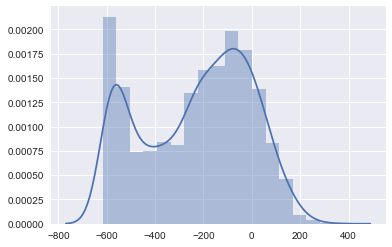

In [174]:
sns.distplot(SVMScoreMin[(df_train.tremorScore==0).values])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


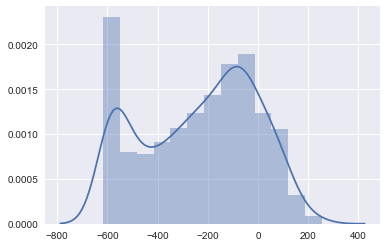

In [173]:
sns.distplot(SVMScoreMin[(df_train.tremorScore>0).values])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


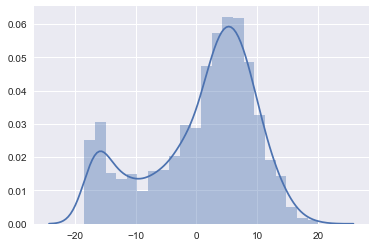

In [176]:
sns.distplot(SVMScoreMin[(df_train.tremorScore==0).values])

/Users/nicholasshawen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


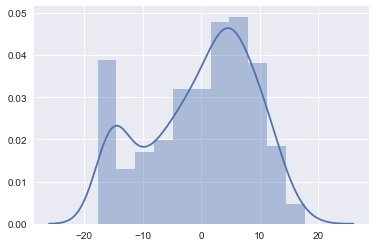

In [177]:
sns.distplot(SVMScoreMin[(df_train.tremorScore>1).values])

In [1]:
flist[-6:]

NameError: name 'flist' is not defined

In [49]:
np.max(np.squeeze(Features,axis=1),axis=0)

array([  1.00000000e+00,   6.00000000e+00,   0.00000000e+00,
         7.00000000e+00,   2.00000000e+00,   1.00000000e+00,
         2.39600000e+01,   5.46936311e+03,   6.19702535e+03,
         7.84496043e+03,   6.05214663e+01,   3.90496806e+01,
         8.38455358e+01,   2.27844392e+00,   2.18520099e+00,
         1.91047212e+00,   5.94732381e+00,   7.54559405e+00,
         5.66180126e+00,   1.48470332e+01,   1.14480062e+01,
         7.59495483e+00,   2.27514565e+02,   1.89988792e+02,
         2.06492727e+02,   1.22720944e+04,   8.64052735e+03,
         2.43548082e+03,   9.96000000e-01,   9.96000000e-01,
         9.96000000e-01,   9.99999996e+00,   8.63167187e-01,
         2.95042554e+00,   6.13337775e+00,   5.86815622e+00,
         3.41915105e+01,   4.53147616e-01,   6.98884088e+00,
         5.70568523e+00,   1.54915066e+02,              inf,
                    inf,              inf,              inf,
                    inf,              inf])

In [44]:
np.squeeze(Features,axis=1).shape

(5105, 47)

In [178]:
sscores=pd.DataFrame(data={'SVMScoreMax':SVMScoreMax,'SVMScoreMin':SVMScoreMin,'SVMScoreMedian':SVMScoreMedian,
                  'SVMScoreMean':SVMScoreMean,'SVMScoreStd':SVMScoreStd,'SVMScore25':SVMScore25,'SVMScore75':SVMScore75}) 

In [179]:
#save the sscores
sscores.to_csv('Trem_Train_SScores.csv',index=False)

In [180]:
sscores.index=X_meta.index
X = pd.concat((X_meta,sscores[['SVMScoreMin']]),axis=1)


In [182]:
X.drop(['patient'],axis=1).to_csv("SVM_Test3.csv")

In [45]:
#load features
filename = 'Features_unnormalized.csv'
df_feat = pd.read_csv(filename)
df_feat.index = df_train.index
#add fileId, target and patient (to keep track of dropped rows)
X = pd.concat((X_meta.iloc[:,0],df_feat),axis=1)
X['patient'] = Metadata['patient']
X['bradykinesiaScore']=df_train['bradykinesiaScore']
#drop nans and store separately the score
X=X.dropna()
y = X['bradykinesiaScore'].values
groups = X['patient']
X = X.drop('bradykinesiaScore',axis=1)
X = X.drop('patient',axis=1)
#add index to sscores and concatenate to other features
sscores.index=X.index
X = pd.concat((X,sscores),axis=1)
#standardize features
scaler = StandardScaler()
X.iloc[:,1:]=scaler.fit_transform(X.iloc[:,1:])

FileNotFoundError: File b'Features_unnormalized.csv' does not exist

In [341]:
X.head()

,dataFileHandleId,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,...,jerk_std,jerk_skew,jerk_kur,SVMScore25,SVMScore75,SVMScoreMax,SVMScoreMean,SVMScoreMedian,SVMScoreMin,SVMScoreStd
25819_22,17286028,-0.460739,-0.554383,-0.734066,-0.749468,-1.311779,-1.086488,-0.085276,0.005512,0.040137,...,-0.847169,1.285868,0.546600,-1.304407,-0.395617,-0.170443,-0.701715,-0.363260,-0.985201,0.837066
25820_22,17286030,-0.406806,-0.375379,-0.616679,-0.763467,-0.633755,-0.843581,0.099766,0.370935,-0.203844,...,-0.685110,0.717222,-0.154402,0.253925,0.126600,0.072570,0.253158,0.320171,0.062849,-0.352609
25821_22,17286034,-0.310379,-0.364372,-0.578126,-0.494683,-0.282922,-0.796560,0.063283,0.017561,0.004127,...,-0.792078,0.001519,-0.271015,-0.971369,-1.332533,-1.516577,-1.182357,-1.194811,-0.279008,-1.287595
25822_22,17286036,-0.330647,-0.341429,-0.355607,-0.409179,-0.688793,-0.606987,-0.050726,-0.002726,0.055454,...,-0.726964,-0.583552,-0.108957,-0.870597,-1.280451,-1.531320,-1.103975,-1.113008,-0.266107,-1.392541
25824_22,17286042,-0.455949,-0.505804,-0.727894,-0.950619,-0.925947,-1.333126,-0.511436,-0.355837,-0.177313,...,-0.908352,-0.152876,-0.327839,-0.036136,0.030493,0.019477,0.094938,0.107224,0.597663,-0.386465


In [335]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3),
          SVC(kernel='rbf',C=1,cache_size=800,probability=True,random_state=3),
          XGBClassifier(n_estimators=150,subsample=1,learning_rate=0.5,max_depth=2)
         ]
model_name = ['Random Forest','Gradient Boosting','SVM','XGB']

In [336]:
#create dataframe to store posterior scores from each clf
Fnew = X.copy()
Fnew=Fnew[['dataFileHandleId']]
for m in model_name:
    Fnew[m]=0
Fnew.index=range(len(Fnew)) #reindex array
# Fnew.head()

In [337]:
#LOSO CV - Compute prediction posteriors from each classifier and aggregate
#drop 
# X = X.iloc[:,1:].as_matrix() #drop fileid 
m = zip(models,model_name)
Fnew = LOSOCV(X.iloc[:,1:].as_matrix(),y,groups,m,Fnew)

Training Random Forest
Random Forest, mean F1 on training set = 1.000 (+/- 0.000)
Random Forest, mean Prec = 0.506 (+/- 0.195)
Random Forest, mean Rec = 0.287 (+/- 0.125)
Training Gradient Boosting
Gradient Boosting, mean F1 on training set = 0.744 (+/- 0.007)
Gradient Boosting, mean Prec = 0.532 (+/- 0.191)
Gradient Boosting, mean Rec = 0.283 (+/- 0.123)
Training SVM
SVM, mean F1 on training set = 0.643 (+/- 0.011)
SVM, mean Prec = 0.559 (+/- 0.204)
SVM, mean Rec = 0.178 (+/- 0.080)
Training XGB
XGB, mean F1 on training set = 0.948 (+/- 0.002)
XGB, mean Prec = 0.525 (+/- 0.160)
XGB, mean Rec = 0.390 (+/- 0.101)


### Make submisssion

In [353]:
clfxgb = models[3]

In [355]:
clfxgb.feature_importances_.shape

(41,)

In [347]:
Fnew.head()

,dataFileHandleId,Random Forest,Gradient Boosting,SVM,XGB
0,17286028,0.30,0.166298,0.135550,0.173430
1,17286030,0.12,0.126891,0.142753,0.214902
2,17286034,0.32,0.474954,0.181625,0.270035
3,17286036,0.30,0.209473,0.205921,0.221518
4,17286042,0.56,0.561740,0.127604,0.159283


In [356]:
Fnew.to_csv('Submission_FwSs_Stacking.csv',index=False)

In [184]:
%run sc2FitModels_LOSOCV.py 'tremor' SVM_Test3.csv

Welcome, Nicholas Shawen!

AUPRC: 0.892


In [357]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_FwSs_Stacking.csv

Welcome, Luca Lonini!

AUPRC: 0.576


In [185]:
X

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration,SVMScoreMin
25819_22,17286028,0,2,1,0,0,1,1,1.014863,-2.674450
25820_22,17286030,1,2,1,0,0,1,0,1.014863,-1.800807
25821_22,17286034,0,2,1,0,1,1,1,6.984001,-8.937845
25822_22,17286036,1,2,1,0,1,1,0,6.984001,-8.991113
25824_22,17286042,1,2,1,0,2,1,0,-0.974849,3.154763
25826_22,17286048,1,2,1,0,3,1,0,-0.974849,3.727398
25827_22,17286052,0,2,1,0,4,1,1,-0.974849,7.310012
25829_22,17286058,0,2,1,0,5,1,1,-0.880101,8.942900
25831_22,17286064,0,2,1,0,6,1,1,0.446374,4.361210
25832_22,17286066,1,2,1,0,6,1,0,0.446374,6.914857
